# Multi Layer Perceptron

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2023-03-25 07:14:47.780641: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-25 07:14:47.933589: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-25 07:14:49.802293: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriat

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 103725586219510080
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 48974397440
 locality {
   bus_id: 2
   numa_node: 1
   links {
   }
 }
 incarnation: 7079956969708368128
 physical_device_desc: "device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:af:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import tensorflow as tf
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, BatchNormalization, Dropout
from keras.models import Model
from keras.optimizers import Adam

### 데이터 테이블 생성

In [3]:
table_df = pd.read_csv('../data/ulsan_rest_table_ver3.csv')
table_df

,p_id,place_id,u_id,user_id,score,comment
0,0,225토마토스트릿,24506,힘내라힘,2,분위기에 비해 맛은 쏘쏘...
1,0,225토마토스트릿,24493,히둥이,5,NaN
2,0,225토마토스트릿,24328,황영하,5,파스타 너무 맛있게 잘 먹었어요 태화동에 맛집이 별로 없어서 아쉬웠는데 맛집을 발견...
3,0,225토마토스트릿,24247,황규현,5,스테이크 부위가 바뀐것같은데 바뀐고기가 훨씬 좋은것 같아요..!.!!! 육향도 좋고...
4,0,225토마토스트릿,24022,호두과자,5,NaN
...,...,...,...,...,...,...
54495,491,효정밥상,497,bbui bbui,4,가성비 좋은 간장게장 집. 비록 가격이 꾸준히 상승하고있긴 하지만 부담스럽진 않은 ...
54496,491,효정밥상,447,b suwan,5,가성비최고 간정게장집이라고 생각해요. 게장 직접담구는 모습도 볼수있고 직접담그는 만...
54497,491,효정밥상,328,Alex Ha,5,가성비는 대박입니다. 솔직히 맛도 좋음. (간장게장 기준)\n\n좀만 더 깨끗한 ...
54498,491,효정밥상,149,0o0o,5,여긴 진짜 간장게장에 진리다 사장님 이제 포장 안해주셔요 참고하세요 진짜 jmt


In [4]:
print(table_df.isnull().sum())
table_df.drop(columns='comment', inplace=True)
table_df.dropna(axis=0, how='any', inplace=True)

p_id            0
place_id        0
u_id            0
user_id         0
score           0
comment     14275
dtype: int64


In [5]:
table_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54500 entries, 0 to 54499
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   p_id      54500 non-null  int64 
 1   place_id  54500 non-null  object
 2   u_id      54500 non-null  int64 
 3   user_id   54500 non-null  object
 4   score     54500 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 2.1+ MB


In [6]:
data_df = table_df[['u_id', 'p_id', 'score']]
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54500 entries, 0 to 54499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   u_id    54500 non-null  int64
 1   p_id    54500 non-null  int64
 2   score   54500 non-null  int64
dtypes: int64(3)
memory usage: 1.2 MB


### Train, Test split

In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_df, test_size=0.2, shuffle=True, random_state=42)

In [8]:
n_users = data_df.u_id.unique().shape[0]
n_places = data_df.p_id.unique().shape[0]
print(n_users, n_places)

24545 492


In [9]:
tf.keras.backend.clear_session()

### callback

In [10]:
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=8, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    './checkpoint',
    monitor = 'val_loss',
    verbose = 0,
    save_best_only = True,
    save_weights_only = False,
    mode = 'auto',
)

### Model

In [11]:
latent_dim = 100 ## 잠재요인

# Define inputs
place_input = Input(shape=[1],name='place-input')
user_input = Input(shape=[1], name='user-input')

# MLP Embeddings
place_embedding_mlp = Embedding(n_places, latent_dim, name='place-embedding-mlp')(place_input)
place_vec_mlp = Flatten(name='flatten-place-mlp')(place_embedding_mlp)

user_embedding_mlp = Embedding(n_users, latent_dim, name='user-embedding-mlp')(user_input)
user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

# MF Embeddings
place_embedding_mf = Embedding(n_places + 1, latent_dim, name='place-embedding-mf')(place_input)
place_vec_mf = Flatten(name='flatten-place-mf')(place_embedding_mf)

user_embedding_mf = Embedding(n_users + 1, latent_dim, name='user-embedding-mf')(user_input)
user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

# MLP layers
concat = Concatenate()([place_vec_mlp, user_vec_mlp])
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
fc_1_dropout = Dropout(0.2)(fc_1_bn)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
fc_2_dropout = Dropout(0.2)(fc_2_bn)

# Prediction from both layers
pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
pred_mf = Dot(axes = 1, normalize=False)([place_vec_mf, user_vec_mf])
combine_mlp_mf = Concatenate()([pred_mf, pred_mlp])


# Final prediction
result = Dense(1, name='result', activation='relu')(combine_mlp_mf)

model = Model([user_input, place_input], result)
model.compile(optimizer=Adam(learning_rate=0.005), loss='mse')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 place-input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 user-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 place-embedding-mlp (Embedding  (None, 1, 100)      49200       ['place-input[0][0]']            
 )                                                                                                
                                                                                                  
 user-embedding-mlp (Embedding)  (None, 1, 100)      2454500     ['user-input[0][0]']         

2023-03-25 07:14:57.158780: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46705 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:af:00.0, compute capability: 8.6


__________________________________________________________________________________________________


### Model Trainning

In [12]:
history = model.fit(x=[train.u_id, train.p_id],y= train.score, validation_split=0.2, epochs=100, verbose=1, callbacks=[earlystopping])

Epoch 1/100
  22/1090 [..............................] - ETA: 8s - loss: 8.0834 

2023-03-25 07:15:01.749665: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1090/1090 [==============================] - 12s 9ms/step - loss: 1.6709 - val_loss: 1.2056
Epoch 2/100
1090/1090 [==============================] - 9s 9ms/step - loss: 0.6522 - val_loss: 1.2168
Epoch 3/100
1090/1090 [==============================] - 10s 9ms/step - loss: 0.3186 - val_loss: 1.2349
Epoch 4/100
1090/1090 [==============================] - 9s 9ms/step - loss: 0.1378 - val_loss: 1.1994
Epoch 5/100
1090/1090 [==============================] - 9s 8ms/step - loss: 0.1035 - val_loss: 1.1951
Epoch 6/100
1090/1090 [==============================] - 9s 8ms/step - loss: 0.0911 - val_loss: 1.2035
Epoch 7/100
1090/1090 [==============================] - 9s 8ms/step - loss: 0.0915 - val_loss: 1.2168
Epoch 8/100
1090/1090 [==============================] - 9s 9ms/step - loss: 0.0830 - val_loss: 1.2046
Epoch 9/100
1090/1090 [==============================] - 9s 8ms/step - loss: 0.0743 - val_loss: 1.1923
Epoch 10/100
1090/1090 [==============================] - 9s 8ms/step - loss: 0.068

### Loss graph

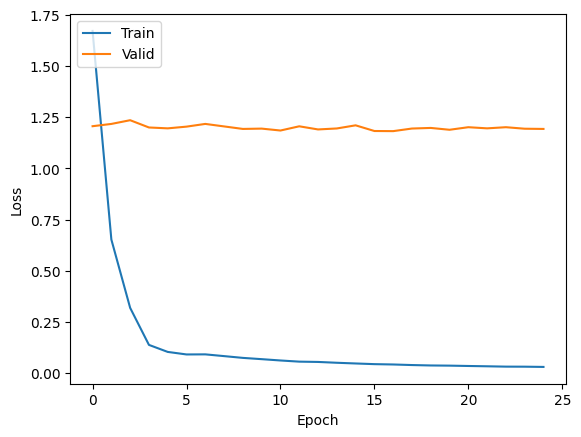

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()
plt.show()

In [14]:
model.evaluate([test.u_id, test.p_id], test.score)

341/341 [==============================] - 1s 3ms/step - loss: 1.2197


1.2197496891021729

### 성능평가(RMSE)

In [15]:
from sklearn.metrics import mean_squared_error
y_prob = model.predict([test.u_id, test.p_id])
y_true = test.score
mean_squared_error(y_true, y_prob)**0.5

341/341 [==============================] - 1s 3ms/step


1.1044226397185264